In [1]:
import ads
import numpy as np
import matplotlib.pyplot as plt
import re
from unidecode import unidecode
from astropy.time import Time

In [2]:
#List of UDP Astro faculty
faculty = [
    "Aravena, M",
    "Assef, R",
    "Cieza, L",
    "Jenkins, J",
    "Johnston, E",
    "Jofre, P",
    "Mazzucchelli, C",
    "Prieto, J",
    "Ricci, C",
    "Yang, B",
    "Zurlo, A"
]

In [3]:
#List of UDP Astro students
students = [
    'Batalla Falcon, G', 
    'Brito Silva, D', 
    'Chavan, P',
    'De Brito Silva, D', 
    'de Almeida, F',
    'Dimopoulos, G',
    'Gonzalez Ruilova, C',
    'Gupta, K',
    'Hosseini, H',
    'Hoy, K',
    'Hueichapan, E',
    'Jegatheesan, K',
    'Kallova, K',
    'Lambert, T', 
    'Nogueira, P', 
    'Pena Rojas, P',
    'Pena, P',
    'Pessi, T',
    'Posses, A', 
    'Signor, T',
    'Solimano, M',
    'Vitali, S',
    'Zewdie, D', 
    'de Brito Silva, D'
]

In [4]:
#People that publish with the UDP affiliation, but are not faculty, postdocs or students. Mostly students that are not part of the Ph.D. program, adjunct faculty, and Erika. 
others_UDP = [
    'Ruiz Rodriguez, D', 
    'Madler, T', 
    'Infante, L', 
    'Labbe, E', 
    'Labbe Waghorn', 
    'Li, G', 
    'Walsen, K',
]

In [5]:
#People that have incorrectly had the affiliation in a paper.
black_listed = [
    'Albarracin, R',
    'Apostolovski, Y',
    'Avenhaus, H',
    'Baughman, J', 
    'Brodie, J',
    'Carbillet, M', 
    'Casassus, S', 
    'Chauvin, G', 
    'Desgrange, C',
    'Deeg, H',
    'Gilmore, G', 
    'Honig, S',
    'Kochanek, C',
    'Lopez, H',
    'Perez, S',
    'Phadke, K',
    'Ramirez, R', 
    'Reuter, C',
    'Rouan, D',
    'Schmidt, T',
]

In [6]:
#Search for all papers from UDP in ADS in a given year.
def paper_search(year):
    q = ads.SearchQuery(aff="portales", year="{}".format(year), fl=["author", "citation_count", "aff", "property", "doctype", "title", "pubdate","bibcode"], max_pages=100)
    #print(year)
    #input()
    ql = list(q)
    return ql

In [7]:
def proc_name(input_name):
    name = unidecode(input_name)
    name = re.sub("-"," ", name)
    name = re.sub("^(.*?\, .).*$",r"\1", name)
    return name

In [8]:
#Distribute publications between UDP authors.
def get_n_papers(ads_query_list, UDP_Astro_names, count_as_incentives=True, only_faculty=False):
    n_papers = dict()
    for paper in ads_query_list:

        #Only process refereed articles.
        if 'REFEREED' in paper.property and paper.doctype=='article':
            pass
        else:
            continue

        #Separate the classes for ease of use. 
        faculty = UDP_Astro_names['Faculty']
        students = UDP_Astro_names['Students']
        postdocs = UDP_Astro_names['Postdocs']
        others_UDP = UDP_Astro_names['Others']

        #Case 1: First author is a Ph.D. Student or a Postdoc. In that case, the student or the postdocs get the full incentivo. This case only applies when we are counting for incentivos. 
        k = 0
        first_author = proc_name(paper.author[k])
        if count_as_incentives:
            if re.search("portales", paper.aff[k], flags=re.IGNORECASE) and re.search("astro", paper.aff[k], flags=re.IGNORECASE) and first_author not in black_listed:
                if count_as_incentives and not only_faculty and first_author not in black_listed and (first_author in students or first_author in postdocs):
                    if first_author not in n_papers:
                        n_papers[first_author] = 0.
                    n_papers[first_author] += 1.
                    continue

        #Case 2: Another person is the first author and we are either counting papers as for incentives or for astro faculty only. In that case, we only split the papers between the faculty that are co-authors in that paper. We will assume the split is equal among them. 
        udp_authors = list()
        if count_as_incentives or only_faculty:
            for k in range(len(paper.author)):
                name = proc_name(paper.author[k])
                if name in faculty:
                    if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                            udp_authors.append(name)

        #Case 3: We are not counting papers as for incentivos, but also not considering only faculty. This is really only useful to get the full number of papers from UDP. 
        if not count_as_incentives and not only_faculty:
            for k in range(len(paper.author)):
                name = proc_name(paper.author[k])
                if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                    if name in faculty or (re.search("astro", paper.aff[k], flags=re.IGNORECASE) and name not in black_listed):
                        udp_authors.append(name)     

        if len(udp_authors)==0:
            continue

        #Now, set the fraction at which we will count each paper. 
        if count_as_incentives or (not count_as_incentives and not only_faculty):
            frac = 1./len(udp_authors)
        else:
            frac = 1

        #Finally, add them. 
        for name in udp_authors:
            if name not in n_papers:
                n_papers[name] = 0
            n_papers[name] += frac

    return n_papers

In [9]:
#Distribute publications between UDP authors.
def count_papers_udp_top_m_authors(ads_query_list, UDP_Astro_names, m=10, only_faculty=False):
    n_papers = 0
    for paper in ads_query_list:

        #Only process refereed articles.
        if 'REFEREED' in paper.property and paper.doctype=='article':
            pass
        else:
            continue

        #Separate the classes for ease of use. 
        faculty = UDP_Astro_names['Faculty']
        students = UDP_Astro_names['Students']
        postdocs = UDP_Astro_names['Postdocs']
        others_UDP = UDP_Astro_names['Others']

        m_use = min([m, len(paper.author)])
        for k in range(m_use):
            name = proc_name(paper.author[k])
            if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                if name in faculty or ((not only_faculty) and re.search("astro", paper.aff[k], flags=re.IGNORECASE) and name not in black_listed):
                    n_papers += 1
                    break

    return n_papers

In [10]:
ql = dict()
years = np.arange(2013, 2026)
for year in years:
    ql[year] = paper_search(year)

In [11]:
#Make a list of postdocs. All people that are not faculty or students and are not blacklisted, should be in the postdocs list.
postdocs = list()
for year in years: 
    for paper in ql[year]: 
        for k in range(len(paper.author)):
            if re.search("portales", paper.aff[k], flags=re.IGNORECASE) and re.search("astro", paper.aff[k], flags=re.IGNORECASE):
                name = proc_name(paper.author[k])
                if name not in faculty and name not in students and name not in others_UDP and name not in black_listed:
                    if name not in postdocs:
                        postdocs.append(name)
print(postdocs)

['Diaz Santos, T', 'Muzic, K', 'Principe, D', 'Romero Canizales, C', 'Jiang, C', 'Bertrang, G', 'Brisbin, D', 'Guaita, L', 'Tucci Maia, M', 'Gonzalez Lopez, J', 'Maia, M', 'Tortosa, A', 'Samadi Ghadim, A', 'Kawamuro, T', 'Temple, M', 'Aguilera Gomez, C', 'Bhowmik, T', 'Rojas, A', 'Rojas Lilayu, A', 'Elgueta, S', 'Shablovinskaya, E', 'Jana, A', 'Liao, M', 'Killi, M', 'Telikova, K', 'Cartier, R', 'Diaz, Y', 'Eldridge, C', 'Harrington, K', 'Saha, S', 'Shablovinskaia, E', 'Petrus, S', 'Slumstrup, D', 'Povick, J', 'Labbe Waghorn, E', 'Alcalde Pampliega, B', 'Dasgupta, A', 'Shobhana, D', 'Hueichapan Diaz, E', 'Gerlach, M', 'Venselaar, S', 'Elford, J', 'Carpenter, J', 'Mkrtchyan, T', 'Pena R., P', 'Ordenes Briceno, Y', 'Serafinelli, R', 'Lavin, R', 'Lopez, D', 'Zhao, R']


In [12]:
#Create a dictionary with all the UDP Astro affiliated people. 
UDP_Astro_names = dict()
UDP_Astro_names['Faculty'] = faculty
UDP_Astro_names['Students'] = students
UDP_Astro_names['Postdocs'] = postdocs
UDP_Astro_names['Others'] = others_UDP

In [13]:
#Sort dividing papers as they go for incentivos.
n_papers1 = dict()
for year in years:
    n_papers1[year] = get_n_papers(ql[year], UDP_Astro_names, count_as_incentives=True, only_faculty=False)

In [14]:
#Print all authors that have used the UDP affiliation.
all_keys = list()
for year in years:
    keys = list(n_papers1[year].keys())
    all_keys.extend(keys)
np.unique(all_keys)

array(['Aguilera Gomez, C', 'Aravena, M', 'Assef, R', 'Batalla Falcon, G',
       'Bertrang, G', 'Brisbin, D', 'Chavan, P', 'Cieza, L',
       'Dasgupta, A', 'De Brito Silva, D', 'Diaz Santos, T',
       'Dimopoulos, G', 'Elford, J', 'Elgueta, S', 'Gonzalez Lopez, J',
       'Gonzalez Ruilova, C', 'Guaita, L', 'Gupta, K', 'Harrington, K',
       'Jana, A', 'Jegatheesan, K', 'Jenkins, J', 'Jofre, P',
       'Johnston, E', 'Kallova, K', 'Kawamuro, T', 'Killi, M',
       'Lambert, T', 'Liao, M', 'Maia, M', 'Mazzucchelli, C', 'Muzic, K',
       'Nogueira, P', 'Pessi, T', 'Petrus, S', 'Posses, A', 'Povick, J',
       'Prieto, J', 'Principe, D', 'Ricci, C', 'Romero Canizales, C',
       'Saha, S', 'Samadi Ghadim, A', 'Shablovinskaya, E', 'Signor, T',
       'Solimano, M', 'Telikova, K', 'Temple, M', 'Tortosa, A',
       'Vitali, S', 'Yang, B', 'Zewdie, D', 'Zhao, R', 'Zurlo, A',
       'de Brito Silva, D'], dtype='<U19')

In [15]:
#Calculate a linear correction for the final year. 
time_now = Time.now()
weights = np.ones(years.shape)
for i, year in enumerate(years):
    time_start_year = Time("{}-01-01 00:00:00".format(year))
    time_end_year = Time("{}-12-31 23:59:59".format(year))
    if time_now<time_end_year:
        weights[i] = (time_now-time_start_year).value/(time_end_year-time_start_year).value
print(weights)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.76370923]


In [16]:
#Get the median for each year. 
median_papers1 = np.zeros(years.shape)
av_papers1 = np.zeros(years.shape)
for i, year in enumerate(years):
    aux = list()
    for name in faculty:
        if name in n_papers1[year]:
            aux.append(n_papers1[year][name])
    #If there is a faculty with no papers in the last year, it should be reflected here. 
    if year==years[-1]:
        for name in faculty:
            if name not in n_papers1[year]:
                aux.append(0)
    median_papers1[i] = np.median(aux)
    av_papers1[i] = np.average(aux)

In [17]:
years_use = years[-4:]
print(years_use)
for name in faculty:
    naux = np.zeros(len(years_use))
    for i, year in enumerate(years_use):
        if name in n_papers1[year]:
            naux[i] = n_papers1[year][name]
    print("{:20s} {:4.1f} {:4.1f} {:4.1f}  {:4.1f}".format(name, naux[0], naux[1], naux[2], naux[3]))

[2022 2023 2024 2025]
Aravena, M           19.0 15.0 17.0  10.3
Assef, R              2.5  4.5  8.5   9.8
Cieza, L              1.8  7.0  5.5  17.0
Jenkins, J            9.0 11.0 11.0   8.0
Johnston, E           8.0  2.0  8.0   5.5
Jofre, P              7.3  7.0  4.5   4.5
Mazzucchelli, C       2.0 11.0 15.0  11.0
Prieto, J            10.0  8.0  4.0   2.0
Ricci, C             29.5 19.5 37.0  33.8
Yang, B               3.0  3.0  3.0   4.0
Zurlo, A             13.8  8.0 14.5   8.0


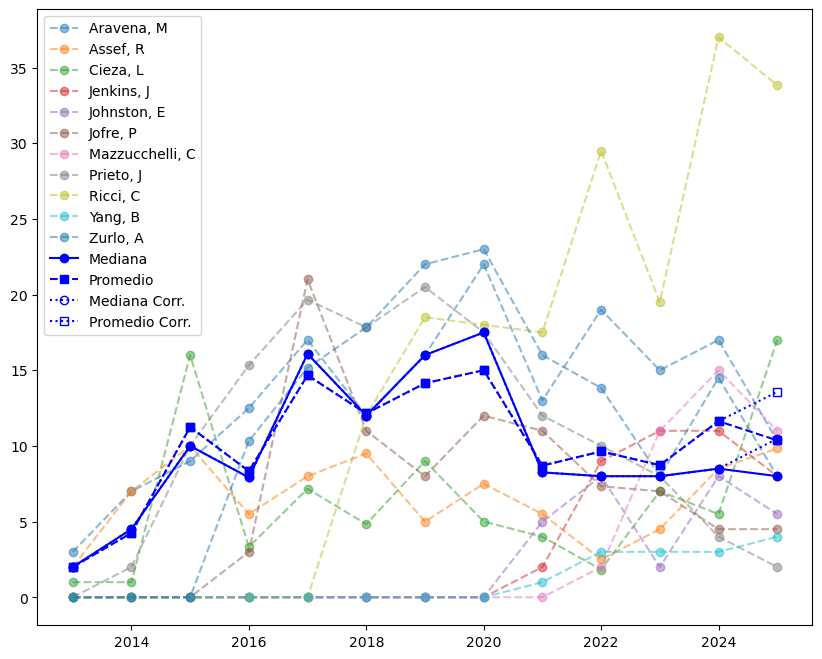

In [18]:
#Plot the evolution of faculty papers counting for incentivos. 
fig, ax = plt.subplots(1, figsize=(10,8))
for name in faculty:
    x = np.zeros(years.shape)
    for k,year in enumerate(years):
        if name in n_papers1[year]:
            x[k] = n_papers1[year][name]
    ax.plot(years, x, '--o', label=name, alpha=0.5)
ax.plot(years, median_papers1, '-bo', label='Mediana')
ax.plot(years, av_papers1, '--bs', label='Promedio')
ax.plot(years, median_papers1/weights, 'bo', label='Mediana Corr.', fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers1/weights, 'bs', label='Promedio Corr.', fillstyle='none', linestyle='dotted')
ax.legend()
plt.show()

In [19]:
#Sort dividing papers only considering faculty.
n_papers2 = dict()
for year in years:
    n_papers2[year] = get_n_papers(ql[year], UDP_Astro_names, count_as_incentives=True, only_faculty=True)

In [20]:
years_use = years[-4:]
print(years_use)
for name in faculty:
    naux = np.zeros(len(years_use))
    for i, year in enumerate(years_use):
        if name in n_papers2[year]:
            naux[i] = n_papers2[year][name]
    print("{:20s} {:4.1f} {:4.1f} {:4.1f}  {:4.1f}".format(name, naux[0], naux[1], naux[2], naux[3]))

[2022 2023 2024 2025]
Aravena, M           20.5 16.0 17.7  12.2
Assef, R              2.5  5.5  9.7  11.7
Cieza, L              1.8  7.5  5.5  19.0
Jenkins, J            9.0 11.0 11.0   9.5
Johnston, E           8.5  2.5  9.8   6.5
Jofre, P              8.8  7.0  9.0   5.5
Mazzucchelli, C       2.0 11.3 15.3  11.3
Prieto, J            11.5 10.5  5.0   2.0
Ricci, C             31.5 24.2 42.5  36.8
Yang, B               3.0  3.0  3.0   6.0
Zurlo, A             13.8  8.5 15.5   9.5


In [21]:
#Get all papers for each faculty.
n_papers_all = dict()
for year in years:
    n_papers_all[year] = get_n_papers(ql[year], UDP_Astro_names, count_as_incentives=False, only_faculty=True)

In [22]:
years_use = years[-4:]
print(years_use)
for name in faculty:
    naux = np.zeros(len(years_use))
    for i, year in enumerate(years_use):
        if name in n_papers_all[year]:
            naux[i] = n_papers_all[year][name]
    print("{:20s} {:4.1f} {:4.1f} {:4.1f}  {:4.1f}".format(name, naux[0], naux[1], naux[2], naux[3]))

[2022 2023 2024 2025]
Aravena, M           21.0 18.0 21.0  18.0
Assef, R              4.0  8.0 18.0  18.0
Cieza, L              3.0 10.0  7.0  21.0
Jenkins, J            9.0 11.0 11.0  10.0
Johnston, E           9.0  3.0 12.0   7.0
Jofre, P             10.0  7.0 10.0   6.0
Mazzucchelli, C       2.0 12.0 16.0  12.0
Prieto, J            12.0 11.0  5.0   2.0
Ricci, C             33.0 26.0 48.0  38.0
Yang, B               3.0  3.0  3.0   6.0
Zurlo, A             15.0 11.0 17.0  12.0


In [23]:
#Get the median for each year. 
median_papers2 = np.zeros(years.shape)
av_papers2 = np.zeros(years.shape)
for i, year in enumerate(years):
    aux = list()
    for name in faculty:
        if name in n_papers2[year]:
            aux.append(n_papers2[year][name])
    #If there is a faculty with no papers in the last year, it should be reflected here. 
    if year==years[-1]:
        for name in faculty:
            if name not in n_papers2[year]:
                aux.append(0)
    median_papers2[i] = np.median(aux)
    av_papers2[i] = np.average(aux)

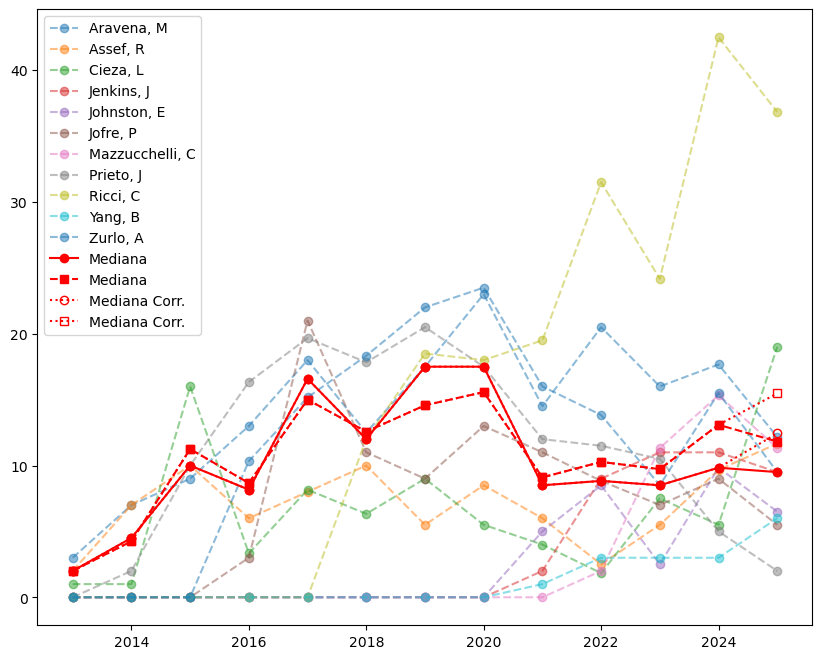

In [24]:
#Plot the evolution of all faculty papers. 
fig, ax = plt.subplots(1, figsize=(10,8))
for name in faculty:
    x = np.zeros(years.shape)
    for k,year in enumerate(years):
        if name in n_papers2[year]:
            x[k] = n_papers2[year][name]
    ax.plot(years, x, '--o', label=name, alpha=0.5)
ax.plot(years, median_papers2, '-ro', label='Mediana')
ax.plot(years, av_papers2, '--rs', label='Mediana')
ax.plot(years, median_papers2/weights, 'ro', label='Mediana Corr.', fillstyle='none',linestyle='dotted')
ax.plot(years, av_papers2/weights, 'rs', label='Mediana Corr.', fillstyle='none',linestyle='dotted')
ax.legend()
plt.show()

In [25]:
#Calculate the average number of papers a faculty member is responsible for. 
n_papers3 = dict()
for year in years:
    n_papers3[year] = get_n_papers(ql[year], UDP_Astro_names, count_as_incentives=False, only_faculty=False)
av_papers3 = np.zeros(years.shape)
nf = np.zeros(years.shape)
ntp = np.zeros(years.shape)
for i,year in enumerate(years):
    #Find how many faculty there were at UDP.
    for name in faculty:
        if name in n_papers3[year]:
            nf[i] += 1
    #In the current year, it has to be equal to the number of faculty, but it is possible a faculty has not published yet.
    if year==years[-1]:
        nf[i] = len(faculty)
    #Now, find the total number of astro papers for that year. 
    ntp[i] = np.sum(list(n_papers3[year].values()))
    #Now, get the average paper per faculty.
    av_papers3[i] = ntp[i]/nf[i]

In [26]:
for i, year in enumerate(years):
    print("{}: {:.1f} ({:.1f})".format(year, ntp[i], nf[i]))
print("Total: {}".format(np.sum(ntp)))

2013: 6.0 (3.0)
2014: 18.0 (4.0)
2015: 59.0 (4.0)
2016: 71.0 (6.0)
2017: 111.0 (6.0)
2018: 111.0 (7.0)
2019: 116.0 (7.0)
2020: 125.0 (7.0)
2021: 117.0 (10.0)
2022: 128.0 (11.0)
2023: 131.0 (11.0)
2024: 180.0 (11.0)
2025: 160.0 (11.0)
Total: 1333.0


In [27]:
#Calculate the number of papers for which there would be no incentivos. 
np_inc = np.zeros(len(years))
for i, year in enumerate(years):
    n_total =  np.sum(list(n_papers3[year].values()))
    np_inc[i] = np.sum(list(n_papers1[year].values()))
    print("{}: {:.1f} {:.1f} {:.1f}".format(year, n_total, np_inc[i], n_total-np_inc[i]))

2013: 6.0 6.0 0.0
2014: 18.0 17.0 1.0
2015: 59.0 46.0 13.0
2016: 71.0 53.0 18.0
2017: 111.0 95.0 16.0
2018: 111.0 88.0 23.0
2019: 116.0 102.0 14.0
2020: 125.0 110.0 15.0
2021: 117.0 94.0 23.0
2022: 128.0 115.0 13.0
2023: 131.0 109.0 22.0
2024: 180.0 154.0 26.0
2025: 160.0 134.0 26.0


/tmp/ipykernel_1415540/1258537075.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-bo" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(years, ntp/weights, '-bo', ls='dotted',fillstyle='none')
/tmp/ipykernel_1415540/1258537075.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-ro" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(years, np_inc/weights, '-ro', ls='dotted',fillstyle='none')
/tmp/ipykernel_1415540/1258537075.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-mo" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(years, (ntp-np_inc)/weights, '-mo', ls='dotted',fillstyle='none')


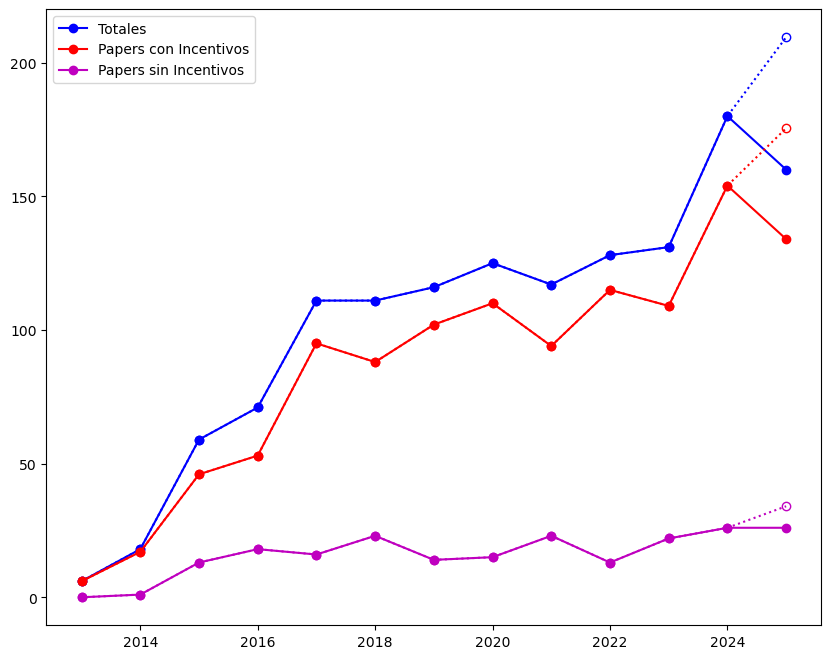

In [28]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years, ntp, '-bo', label='Totales')
ax.plot(years, ntp/weights, '-bo', ls='dotted',fillstyle='none')
ax.plot(years, np_inc, '-ro', label='Papers con Incentivos')
ax.plot(years, np_inc/weights, '-ro', ls='dotted',fillstyle='none')
ax.plot(years, ntp-np_inc, '-mo', label='Papers sin Incentivos')
ax.plot(years, (ntp-np_inc)/weights, '-mo', ls='dotted',fillstyle='none')
ax.legend()
plt.show()

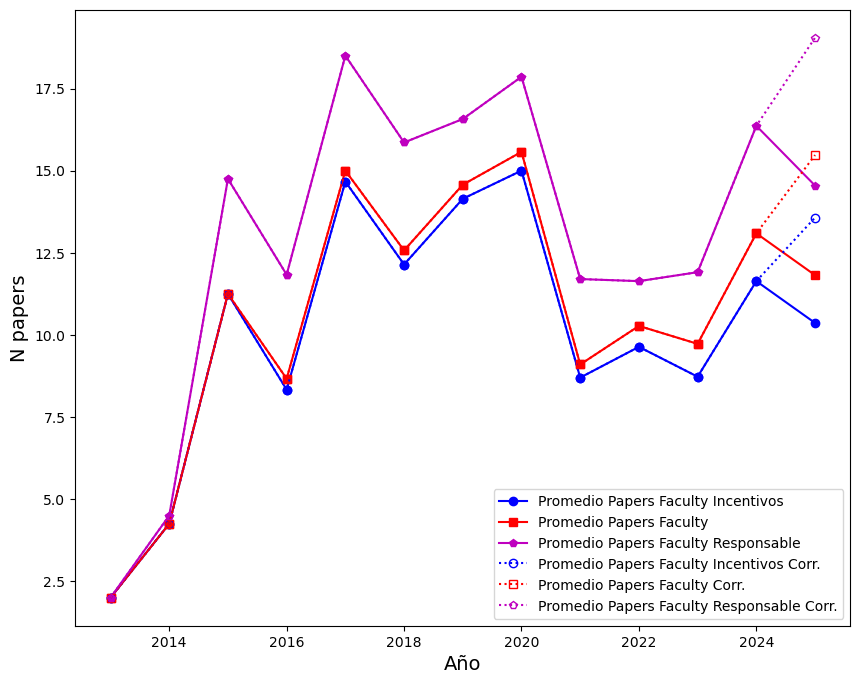

In [29]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years, av_papers1, '-bo', label="Promedio Papers Faculty Incentivos")
ax.plot(years, av_papers2, '-rs', label="Promedio Papers Faculty")
ax.plot(years, av_papers3, '-mp', label="Promedio Papers Faculty Responsable")
ax.plot(years, av_papers1/weights, 'bo', label="Promedio Papers Faculty Incentivos Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers2/weights, 'rs', label="Promedio Papers Faculty Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers3/weights, 'mp', label="Promedio Papers Faculty Responsable Corr.", fillstyle='none', linestyle='dotted')
ax.set_xlabel("Año", fontsize=14)
ax.set_ylabel("N papers", fontsize=14)
ax.legend()
plt.show()

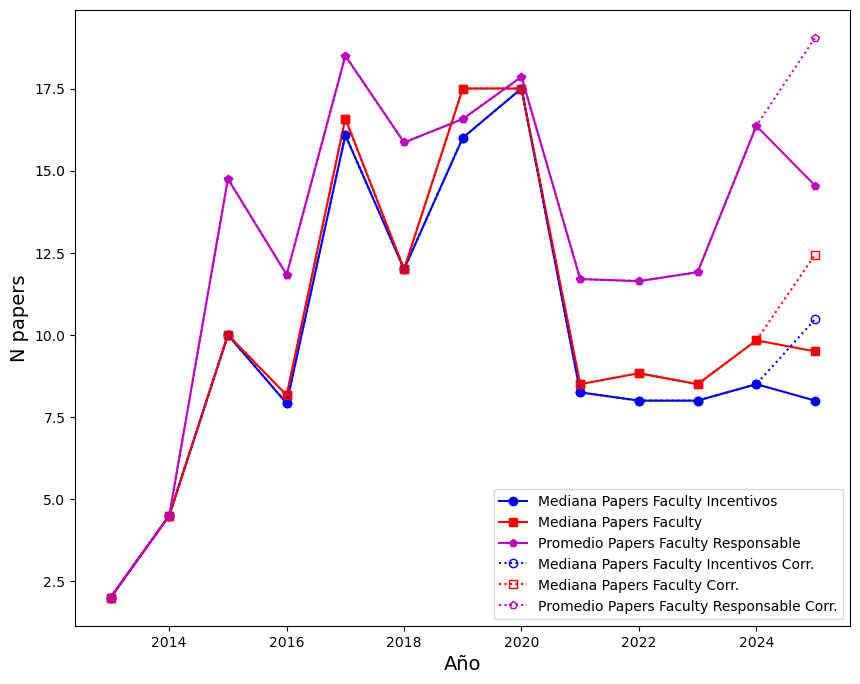

In [30]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years, median_papers1, '-bo', label="Mediana Papers Faculty Incentivos")
ax.plot(years, median_papers2, '-rs', label="Mediana Papers Faculty")
ax.plot(years, av_papers3, '-mp', label="Promedio Papers Faculty Responsable")
ax.plot(years, median_papers1/weights, 'bo', label="Mediana Papers Faculty Incentivos Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, median_papers2/weights, 'rs', label="Mediana Papers Faculty Corr.", fillstyle='none', linestyle='dotted')
ax.plot(years, av_papers3/weights, 'mp', label="Promedio Papers Faculty Responsable Corr.", fillstyle='none', linestyle='dotted')
ax.set_xlabel("Año", fontsize=14)
ax.set_ylabel("N papers", fontsize=14)
ax.legend()
plt.show()

In [31]:
#For each year find the ratio of papers between the first and second halve of the year.
n_paper_first_semester = np.zeros(len(years[1:-1]))
for i, year in enumerate(years[1:-1]):
    month = list()
    for paper in ql[year]:
        #Only process refereed articles.
        if 'REFEREED' in paper.property and paper.doctype=='article':
            pass
        else:
            continue
        for k in range(len(paper.author)):
            name = proc_name(paper.author[k])
            if re.search("portales", paper.aff[k], flags=re.IGNORECASE):
                if name in faculty or (re.search("astro", paper.aff[k], flags=re.IGNORECASE) and name not in black_listed):
                    month.append(float(paper.pubdate.split("-")[1]))
                    break
    month = np.array(month)
    n_paper_first_semester[i] = len(month[month<=6])/len(month)

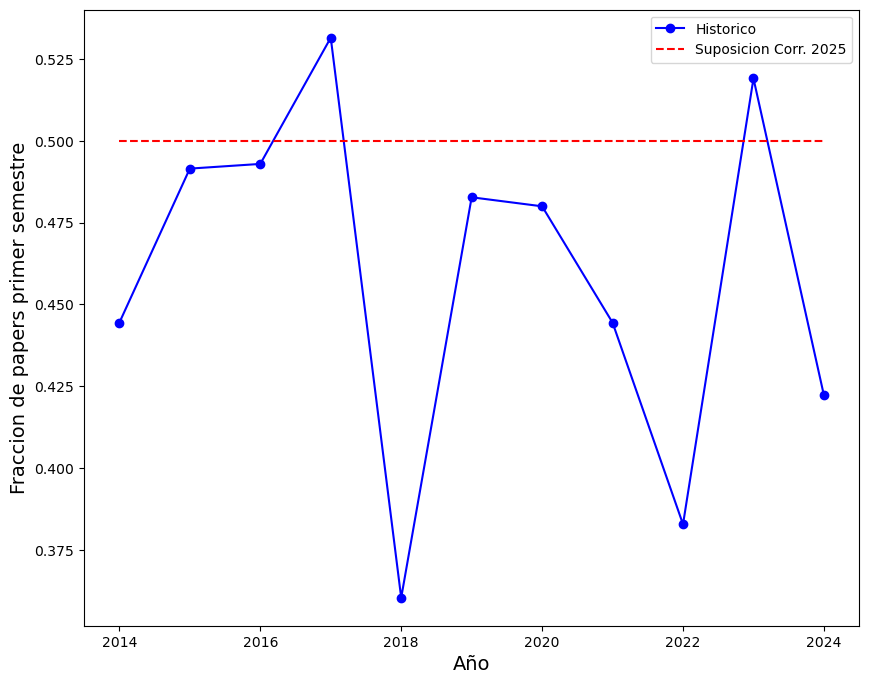

In [32]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.plot(years[1:-1], n_paper_first_semester, "-bo", label='Historico')
ax.plot(years[1:-1], 0.5*np.ones(years[1:-1].shape), '--r', label='Suposicion Corr. {}'.format(years[-1]))
ax.set_ylabel("Fraccion de papers primer semestre", fontsize=14)
ax.set_xlabel("Año", fontsize=14)
ax.legend()
plt.show()


In [33]:
#Count the number of papers in which a UDP person is within the first 10 authors.
for year in years: 
    n_total =  np.sum(list(n_papers3[year].values()))
    n_top_10 = count_papers_udp_top_m_authors(ql[year], UDP_Astro_names, m=10)
    print("{:7d} {:5.0f} {:6.0f} ({:.1f}%)".format(year, n_top_10, n_total, (n_top_10/n_total)*100))

   2013     5      6 (83.3%)
   2014    16     18 (88.9%)
   2015    50     59 (84.7%)
   2016    57     71 (80.3%)
   2017    74    111 (66.7%)
   2018    69    111 (62.2%)
   2019    73    116 (62.9%)
   2020    85    125 (68.0%)
   2021    67    117 (57.3%)
   2022    84    128 (65.6%)
   2023    94    131 (71.8%)
   2024   107    180 (59.4%)
   2025   103    160 (64.4%)


In [34]:
#Count the number of papers in which a UDP Faculty is within the first 10 authors.
for i, year in enumerate(years): 
    n_total =  np.sum(list(n_papers3[year].values()))
    n_top_10 = count_papers_udp_top_m_authors(ql[year], UDP_Astro_names, m=10, only_faculty=True)
    print("{:7d} {:5.0f} {:6.0f} ({:.1f}%) {:6.0f} ({:.1f}%)".format(year, n_top_10, np_inc[i], (n_top_10/np_inc[i])*100, n_total, (n_top_10/n_total)*100))

   2013     5      6 (83.3%)      6 (83.3%)
   2014    16     17 (94.1%)     18 (88.9%)
   2015    37     46 (80.4%)     59 (62.7%)
   2016    41     53 (77.4%)     71 (57.7%)
   2017    54     95 (56.8%)    111 (48.6%)
   2018    52     88 (59.1%)    111 (46.8%)
   2019    61    102 (59.8%)    116 (52.6%)
   2020    74    110 (67.3%)    125 (59.2%)
   2021    49     94 (52.1%)    117 (41.9%)
   2022    74    115 (64.3%)    128 (57.8%)
   2023    75    109 (68.8%)    131 (57.3%)
   2024    81    154 (52.6%)    180 (45.0%)
   2025    80    134 (59.7%)    160 (50.0%)


In [35]:
#Count the number of papers in which a UDP Faculty is within the first 50 authors.
for i, year in enumerate(years): 
    n_total =  np.sum(list(n_papers3[year].values()))
    n_top_50 = count_papers_udp_top_m_authors(ql[year], UDP_Astro_names, m=50, only_faculty=True)
    print("{:7d} {:5.0f} {:6.0f} ({:.1f}%) {:6.0f} ({:.1f}%)".format(year, n_top_50, np_inc[i], (n_top_50/np_inc[i])*100, n_total, (n_top_50/n_total)*100))

   2013     6      6 (100.0%)      6 (100.0%)
   2014    16     17 (94.1%)     18 (88.9%)
   2015    42     46 (91.3%)     59 (71.2%)
   2016    51     53 (96.2%)     71 (71.8%)
   2017    89     95 (93.7%)    111 (80.2%)
   2018    84     88 (95.5%)    111 (75.7%)
   2019    99    102 (97.1%)    116 (85.3%)
   2020   105    110 (95.5%)    125 (84.0%)
   2021    89     94 (94.7%)    117 (76.1%)
   2022   109    115 (94.8%)    128 (85.2%)
   2023   105    109 (96.3%)    131 (80.2%)
   2024   139    154 (90.3%)    180 (77.2%)
   2025   126    134 (94.0%)    160 (78.8%)


In [36]:
from useful_functions import filter_papers
for year in [2022, 2023]:
    papers = filter_papers(ql[year])
    print(year, len(papers), "papers")
    for paper in papers:
        print(paper.bibcode)
    print()

2022 128 papers
2022ApJS..261....2K
2022ApJ...938...87K
2022A&A...666A.121R
2022ApJ...931..160B
2022MNRAS.513.2719V
2022ApJ...939L..16Z
2022ApJS..261....5M
2022ApJ...941..106F
2022MNRAS.513.3122S
2022A&A...666A.133Z
2022ApJ...938...67R
2022MNRAS.515.3126I
2022MNRAS.512...58F
2022MNRAS.517.2214F
2022A&A...664A..46A
2022ApJ...939L..13A
2022A&A...664A..94P
2022A&A...666A.120G
2022ApJS..261....9A
2022ApJS..261....4O
2022A&A...663A.144B
2022A&A...666A..32X
2022ApJ...935...17S
2022MNRAS.515.1751W
2022MNRAS.512..989D
2022A&A...664A.139D
2022MNRAS.513.1557C
2022ApJ...927...65G
2022MNRAS.509.3599T
2022ApJ...938...54R
2022ApJS..262...49K
2022MNRAS.510.1248M
2022ApJ...940...52S
2022ApJ...934...35M
2022ApJS..261....1K
2022A&A...662A..33L
2022A&A...667A.156B
2022A&A...664A..92H
2022A&A...668A.138H
2022ApJ...930..171H
2022NatAs...6.1364G
2022A&A...666A..46U
2022ApJS..261....6K
2022ApJ...933...70L
2022ApJ...927...36W
2022MNRAS.514.6141J
2022ApJ...924...76A
2022MNRAS.517.2190R
2022MNRAS.516.5331M
2022